# Braden-Scaling IQNx4: 1.Mass (UNDER CONSTRUCTION!)

# Do `source setup.sh` before trying to run this notebook!



## External Imports

If you don't have some of these packages installed, you can also use the conda environment that has all of the packages by doing `conda env create -f IQN_env.yml && conda activate IQN_env`

There is also a `requirements.txt` here so that it can be run on an interactive website, eg binder or people can `pip install` it.

In [1]:
import numpy as np; import pandas as pd
import scipy as sp; import scipy.stats as st
import torch; import torch.nn as nn; print(f"using torch version {torch.__version__}")
#use numba's just-in-time compiler to speed things up
from numba import njit
from sklearn.preprocessing import StandardScaler; from sklearn.model_selection import train_test_split
import matplotlib as mp; import matplotlib.pyplot as plt; 
#reset matplotlib stle/parameters
import matplotlib as mpl
#reset matplotlib parameters to their defaults
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use('seaborn-deep')
mp.rcParams['agg.path.chunksize'] = 10000
font_legend = 15; font_axes=15
# %matplotlib inline
import copy; import sys; import os
from IPython.display import Image, display
from importlib import import_module

try:
    import optuna
    print(f"using (optional) optuna version {optuna.__version__}")
except Exception:
    print('optuna is only used for hyperparameter tuning, not critical!')
    pass
import argparse
import time
# import sympy as sy
import ipywidgets as wid; 

using torch version 1.9.0
using (optional) optuna version 2.8.0


## Import utils, and set environemnt variables

In [2]:
try:
    IQN_BASE = os.environ['IQN_BASE']
    print('BASE directoy properly set = ', IQN_BASE)
    utils_dir = os.path.join(IQN_BASE, 'utils')
    sys.path.append(utils_dir)
    import utils
    #usually its not recommended to import everything from a module, but we know
    #whats in it so its fine
    from utils import *
    print('DATA directory also properly set, in %s' % os.environ['DATA_DIR'])
except Exception:
    print("""\nBASE directory not properly set. Read repo README.\
    If you need a function from utils, use the decorator below, or add utils to sys.path\n
    You can also do os.environ['IQN_BASE']=<ABSOLUTE PATH FOR THE IQN REPO>""")
    pass

BASE directoy properly set =  /home/ali/Desktop/Pulled_Github_Repositories/torchQN
DATA directory also properly set, in /home/ali/Desktop/Pulled_Github_Repositories/IQN_HEP/Davidson/data


### A user is competent enought to do `source setup.sh` on a `setup.sh` script that comes in the repo, such as the next cell uncommented

In [3]:
# %%writefile setup.sh
# #!/bin/bash
# export IQN_BASE=/home/ali/Desktop/Pulled_Github_Repositories/torchQN
# #DAVIDSON
# #export DATA_DIR='/home/DAVIDSON/alalkadhim.visitor/IQN/DAVIDSON_NEW/data'
# #LOCAL
# export DATA_DIR='/home/ali/Desktop/Pulled_Github_Repositories/IQN_HEP/Davidson/data'
# echo 'DATA DIR'
# ls -l $DATA_DIR
# #ln -s $DATA_DIR $IQN_BASE, if you want
# #conda create env -n torch_env -f torch_env.yml
# #conda activate torch_env
# mkdir -p ${IQN_BASE}/images/loss_plots ${IQN_BASE}/trained_models  ${IQN_BASE}/hyperparameters ${IQN_BASE}/predicted_data
# tree $IQN_BASE

In [4]:
# update fonts
FONTSIZE = 14
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : FONTSIZE}
mp.rc('font', **font)

# set usetex = False if LaTex is not 
# available on your system or if the 
# rendering is too slow
mp.rc('text', usetex=True)

# set a seed to ensure reproducibility
seed = 128
rnd  = np.random.RandomState(seed)
#sometimes jupyter doesnt initialize MathJax automatically for latex, so do this:
wid.HTMLMath('$\LaTeX$')

HTMLMath(value='$\\LaTeX$')

## Set arguments and configurations

In [5]:
################################### ARGUMENTS ###################################
parser=argparse.ArgumentParser(description='train for different targets')
parser.add_argument('--N', type=str, help='''size of the dataset you want to use. 
                    Options are 10M and 100K and 10M_2, the default is 10M_2''', required=False,default='10M_2')
#N_epochs X N_train_examples = N_iterations X batch_size
# N_iterations = (N_epochs * train_data.shape[0])/batch_size
#N_iterations = (N_epochs * train_data.shape[0])/64 = 125000 for 1 epoch
parser.add_argument('--n_iterations', type=int, help='''The number of iterations for training, 
                    the default is''', required=False,default=50)
#default=5000000 )
parser.add_argument('--n_layers', type=int, help='''The number of layers in your NN, 
                    the default is 5''', required=False,default=6)
parser.add_argument('--n_hidden', type=int, help='''The number of hidden layers in your NN, 
                    the default is 5''', required=False,default=6)
parser.add_argument('--starting_learning_rate', type=float, help='''Starting learning rate, 
                    the defulat is 10^-3''', required=False,default=1.e-2)
parser.add_argument('--show_loss_plots', type=bool, help='''Boolean to show the loss plots, 
                    default is False''', required=False,default=False)
parser.add_argument('--save_model', type=bool, help='''Boolean to save the trained model dictionary''', 
                    required=False,default=False)
parser.add_argument('--save_loss_plots', type=bool, help='''Boolean to save the loss plots''', 
                    required=False,default=False)


################################### CONFIGURATIONS ###################################
DATA_DIR=os.environ['DATA_DIR']
JUPYTER=True

if JUPYTER:
    args = parser.parse_args(args=[])
    N = '10M_2'
    n_iterations = int(1e4)
    n_layers, n_hidden = int(1), int(10)
    starting_learning_rate = float(1.e-2)
    show_loss_plots = False
    save_model=False
    save_loss_plots = False
else:
    args = parser.parse_args()
    N = args.N
    n_iterations = args.n_iterations
    n_layers = args.n_layers
    n_hidden = args.n_hidden
    starting_learning_rate=args.starting_learning_rate
    show_loss_plots=args.show_loss_plots
    save_model=args.save_model
    save_loss_plots=args.save_loss_plots

dropout=0.2

def get_model_params():
    return n_iterations, n_layers, n_hidden, starting_learning_rate, dropout

### Import the numpy data, convert to dataframe and save (if you haven't saved the dataframes)

# Explore the Dataframe and preprocess

another flowchart for how IQN works autoregressively to get $p_T'$, etc

Plotting

In [9]:
def show_jupyter_image(image_filename, width = 1300, height = 300):
    """Show a saved image directly in jupyter. Make sure image_filename is in your IQN_BASE !"""
    display(Image(os.path.join(IQN_BASE,image_filename), width = width, height = height  ))
    
    
def use_svg_display():
    """Use the svg format to display a plot in Jupyter (better quality)"""
    from matplotlib_inline import backend_inline
    backend_inline.set_matplotlib_formats('svg')

def reset_plt_params():
    """reset matplotlib parameters - often useful"""
    use_svg_display()
    mpl.rcParams.update(mpl.rcParamsDefault)

def show_plot(legend=False):
    use_svg_display()
    plt.tight_layout();
    plt.show()
    if legend:
        plt.legend(loc='best')
        
def set_figsize(get_axes=False,figsize=(7, 7)):
    use_svg_display()
    plt.rcParams['figure.figsize'] = figsize
    if get_axes:
        fig, ax = plt.subplots(1,1, figsize=figsize)
        return fig, ax
    
def set_axes(ax, xlabel, ylabel=None, xmin=None, xmax=None, ymin=None, ymax=None, title=None):
    """saves a lot of time in explicitly difining each axis, its title and labels: do them all in one go"""
    use_svg_display()
    ax.set_xlabel(xlabel,fontsize=font_axes)
    if ylabel:
        ax.set_ylabel(ylabel,fontsize=font_axes)
    if xmin and xmax:
        ax.set_xlim(xmin, xmax)
    
    if ax.get_title()  != '':
        #if the axes (plot) does have a title (which is non-empty string), display it 
        ax.set_title(title)
    if ax.legend():
        #if an axis has a legned label, display it
        ax.legend(loc='best',fontsize=font_legend)
    if ymin and ymax:
        #sometimes we dont have ylimits since we do a lot of histograms, but if an axis has ylimits, set them
        ax.set_ylim(ymin, ymax)
    
    try:
        fig.show()
    except Exception:
        pass
    plt.tight_layout()
    plt.show()

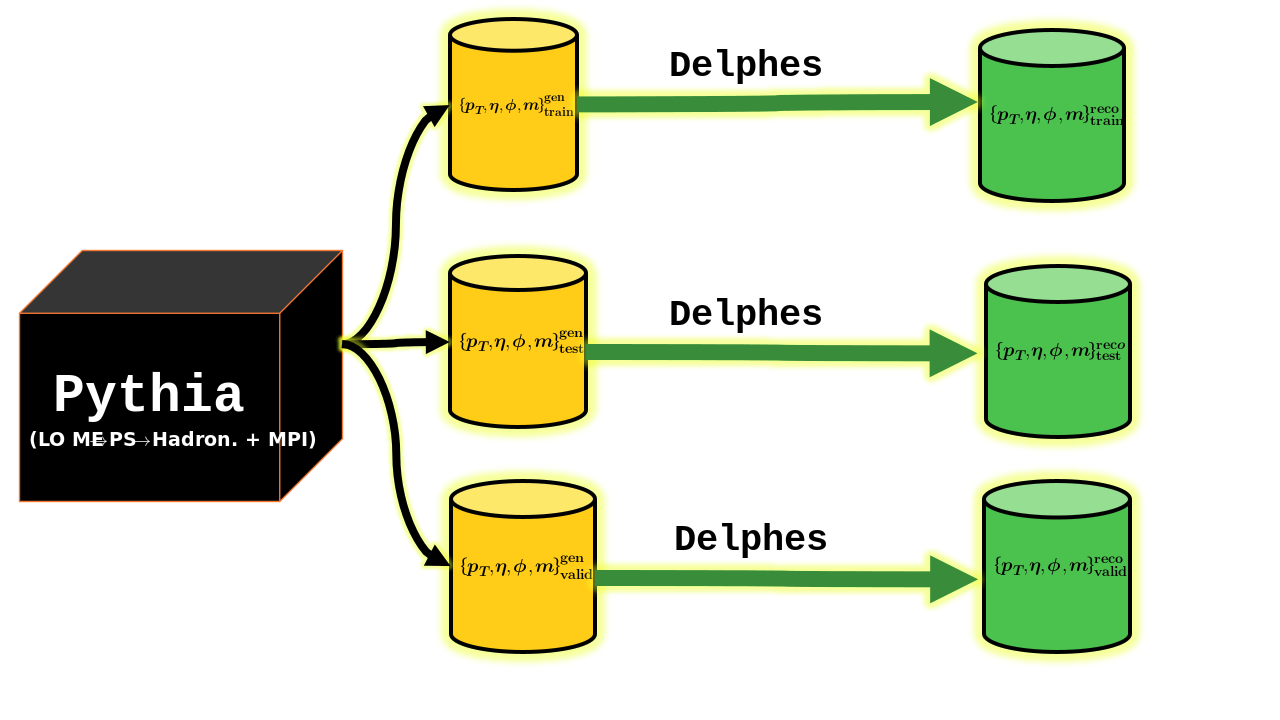

In [10]:
use_svg_display()
show_jupyter_image('images/pythia_ppt_diagram.png', width=2000,height=500)

<!-- For Davidson team, please read try to all the code/comments before asking me questions! -->

In [11]:
################################### SET DATA CONFIGURATIONS ###################################
X       = ['genDatapT', 'genDataeta', 'genDataphi', 'genDatam', 'tau']

FIELDS  = {'RecoDatam' : {'inputs': X, 
                           'xlabel':  r'$m$ (GeV)', 
                           'xmin': 0, 
                           'xmax': 25},
           
           'RecoDatapT': {'inputs': ['RecoDatam']+X, 
                           'xlabel':  r'$p_T$ (GeV)' , 
                           'xmin'  : 20, 
                           'xmax'  :  80},
           
           'RecoDataeta': {'inputs': ['RecoDatam','RecoDatapT'] + X, 
                           'xlabel': r'$\eta$',
                           'xmin'  : -5,
                           'xmax'  :  5},
           
           'RecoDataphi'  : {'inputs': ['RecoDatam', 'RecodatapT', 'RecoDataeta']+X,
                           'xlabel': r'$\phi$' ,
                           'xmin'  : -3.2, 
                           'xmax'  :3.2}
          }

###############################################################################################
y_label_dict ={'RecoDatapT':'$p(p_T)$'+' [ GeV'+'$^{-1} $'+']',
                    'RecoDataeta':'$p(\eta)$', 'RecoDataphi':'$p(\phi)$',
                    'RecoDatam':'$p(m)$'+' [ GeV'+'$^{-1} $'+']'}

loss_y_label_dict ={'RecoDatapT':'$p_T^{reco}$',
                    'RecoDataeta':'$\eta^{reco}$', 'RecoDataphi':'$\phi^{reco}$',
                    'RecoDatam':'$m^{reco}$'}

In [133]:
all_variable_cols=['genDatapT', 'genDataeta', 'genDataphi', 'genDatam','RecoDatapT', 'RecoDataeta', 'RecoDataphi', 'RecoDatam']
all_cols=['genDatapT', 'genDataeta', 'genDataphi', 'genDatam','RecoDatapT', 'RecoDataeta', 'RecoDataphi', 'RecoDatam', 'tau']
################################### Load unscaled dataframes ###################################
SUBSAMPLE=int(1e6)#subsample use for development - in production use whole dataset
train_data=pd.read_csv(os.path.join(DATA_DIR,'train_data_10M_2.csv'),
                      usecols=all_cols,
                      nrows=SUBSAMPLE
                      )

test_data=pd.read_csv(os.path.join(DATA_DIR,'test_data_10M_2.csv'),
                      usecols=all_cols,
                     nrows=SUBSAMPLE
                     )

In [61]:
def explore_data(df, title, scaled=False):
    fig, ax = plt.subplots(1,5, figsize=(15,10) )
    # df = df[['genDatapT', 'genDataeta', 'genDataphi', 'genDatam','RecoDatapT', 'RecoDataeta', 'RecoDataphi', 'RecoDatam']]
    levels = ['RecoData', 'genData']
    kinematics=['pT','eta','phi','m']
    columns = [level+k for level in levels for k in kinematics]
    print(columns)
    columns = columns + ['tau']
    print(columns)
    df = df[columns]
    
    for k_i, k in enumerate(kinematics):
        Reco_var = levels[0]+k
        gen_var = levels[1]+k
        print('Reco_var: ', Reco_var, ', \t gen_var: ', gen_var)
        ax[k_i].hist(df[Reco_var], bins=100, label=Reco_var, alpha=0.35)
        ax[k_i].hist(df[gen_var], bins=100, label=gen_var, alpha=0.35)
        xmin, xmax = FIELDS[Reco_var]['xmin'], FIELDS[Reco_var]['xmax']
        xlabel=FIELDS[Reco_var]['xlabel']
        ax[k_i].set_xlim( (xmin, xmax) )
        # set_axes(ax[k_i], xlabel=xlabel, ylabel='', xmin=xmin, xmax=xmax)
        ax[k_i].set_xlabel(xlabel,fontsize=26)
        
        
                  
        if scaled:
            ax[k_i].set_xlim(df[gen_var].min(),df[gen_var].max() )
        
        ax[k_i].legend(loc='best', fontsize=13)
    ax[4].hist(df['tau'],bins=100, label=r'$\tau$')
    ax[4].legend(loc='best', fontsize=13)
    fig.suptitle(title, fontsize=30)
    show_plot()

['RecoDatapT', 'RecoDataeta', 'RecoDataphi', 'RecoDatam', 'genDatapT', 'genDataeta', 'genDataphi', 'genDatam']
['RecoDatapT', 'RecoDataeta', 'RecoDataphi', 'RecoDatam', 'genDatapT', 'genDataeta', 'genDataphi', 'genDatam', 'tau']
Reco_var:  RecoDatapT , 	 gen_var:  genDatapT
Reco_var:  RecoDataeta , 	 gen_var:  genDataeta
Reco_var:  RecoDataphi , 	 gen_var:  genDataphi
Reco_var:  RecoDatam , 	 gen_var:  genDatam


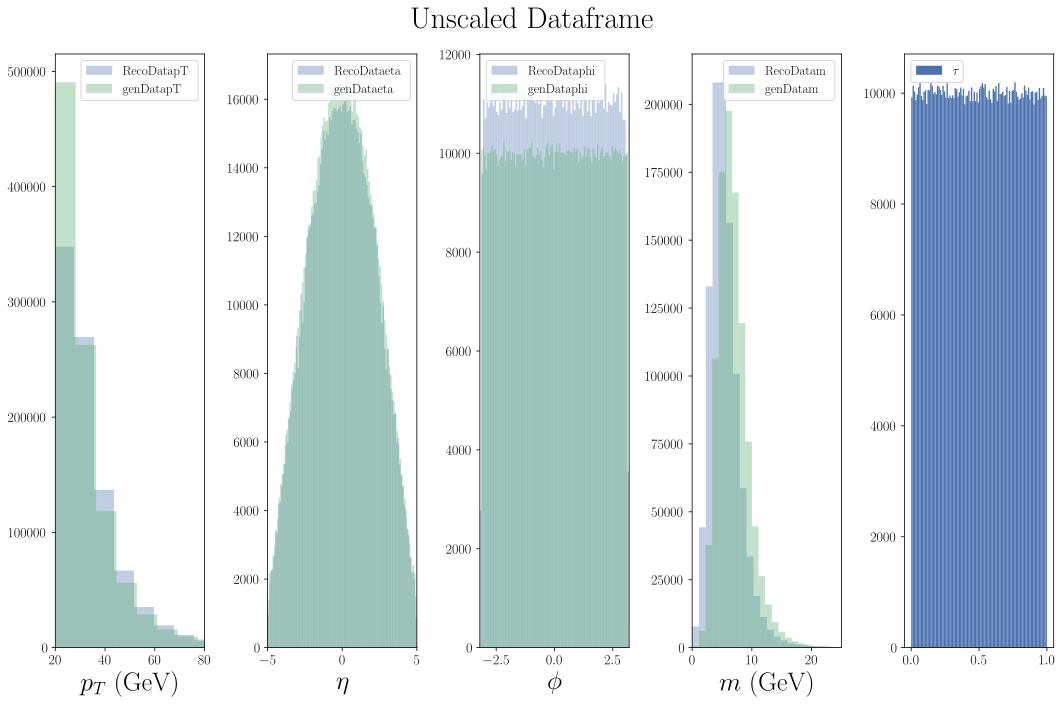

In [62]:
explore_data(df=train_data, title='Unscaled Dataframe')

In [63]:
print(train_data.shape)
train_data.describe()#unscaled

(1000000, 9)


,genDatapT,genDataeta,genDataphi,genDatam,RecoDatapT,RecoDataeta,RecoDataphi,RecoDatam,tau
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,32.677344,-0.005316,0.000987,6.964872,32.829833,-0.005335,0.000812,5.552756,0.499646
std,14.951639,2.210009,1.812815,2.793284,15.833125,2.203636,1.813420,2.678524,0.288680
min,20.000000,-5.201610,-3.141590,-0.000138,11.458500,-4.998990,-3.480195,-0.000068,0.000002
25%,23.763600,-1.663342,-1.567470,5.117530,23.469500,-1.660293,-1.567870,3.802530,0.249248
50%,28.408800,-0.004776,0.004005,6.537520,28.983500,-0.004612,0.003653,5.120240,0.499992
75%,36.247300,1.652610,1.569662,8.281430,37.438400,1.649730,1.570032,6.772080,0.749752
max,839.782000,5.188200,3.141590,111.244000,814.880000,5.005230,3.471905,113.973000,1.000000


In [95]:
def minmax_scale(orig_values):
    # expected_min, expected_max = values.min(), values.max()
    expected_min, expected_max = orig_values.min(), orig_values.max()
    desired_min, desired_max = 1, 7
    scale_factor_expected = expected_max-expected_min
    scale_factor_desired=desired_max-desired_min

    
    
    standarized_values = (orig_values - expected_min)/scale_factor_expected * scale_factor_desired + desired_max 
    return standarized_values

def minmax_de_scale(scaled_values):
    # expected_min, expected_max = values.min(), values.max()
    expected_min, expected_max = 2, 30
    scale_factor = expected_max - expected_min
    offset = expected_min
    de_scaled_values = scale_factor * scaled_values + expected_min
    return de_scaled_values


In [139]:
def sigmoid(unscaled_values):
    unscaled_values= np.array(unscaled_values)
    return 1/(1+ np.exp(- unscaled_values))

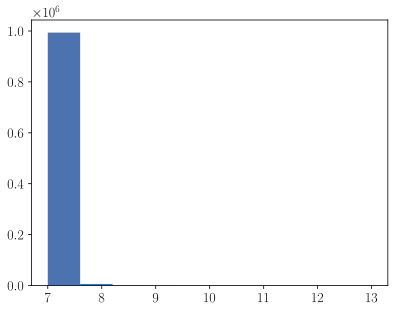

In [96]:
pt_sc = minmax_scale(train_data.iloc[:,0]);plt.hist(pt_sc);plt.show()

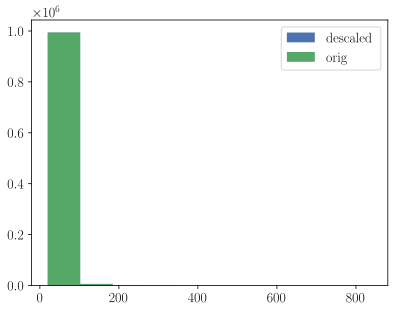

In [66]:
de_scaled_pt=minmax_de_scale(pt_sc);plt.hist(de_scaled_pt,label='descaled');plt.hist(train_data.iloc[:,0],label='orig');plt.legend();plt.show()

In [81]:
def minmax_scale_df(df, title, save=False):
    #scale
    SUBSAMPLE=int(1e4)
    df = df[all_cols]#[:SUBSAMPLE]
    # print(df.head())
    scaled_df = pd.DataFrame()
    #select the columns by index: 
    # 0:genDatapT, 1:genDataeta, 2:genDataphi, 3:genDatam, 
    # 4:RecoDatapT, 5:RecoDataeta, 6:RecoDataphi, 7: Recodatam
    scaled_df['genDatapT'] = minmax_scale(df.iloc[:,0],)
    scaled_df['RecoDatapT'] = minmax_scale(df.iloc[:,4])
    
    scaled_df['genDataeta'] = minmax_scale(df.iloc[:,1])
    scaled_df['RecoDataeta'] = minmax_scale(df.iloc[:,5])
    
    
    scaled_df['genDataphi'] = minmax_scale(df.iloc[:,2])
    scaled_df['RecoDataphi'] = minmax_scale(df.iloc[:,6])

    scaled_df['genDatam'] = minmax_scale(df.iloc[:,3])
    scaled_df['RecoDatam'] = minmax_scale(df.iloc[:,7])
    #why scale tau?
    # scaled_df['tau'] = 6 * df.iloc[:,8] - 3
    scaled_df['tau'] = minmax_scale(df.iloc[:,8])
    
    print(scaled_df.describe())
    
    if save:
        scaled_df.to_csv(os.path.join(DATA_DIR, title) )
    return scaled_df

In [134]:
def sigmoid_scale_df(df, title, save=False):
    #scale
    SUBSAMPLE=int(1e4)
    df = df[all_cols]#[:SUBSAMPLE]
    # print(df.head())
    scaled_df = pd.DataFrame()
    #select the columns by index: 
    # 0:genDatapT, 1:genDataeta, 2:genDataphi, 3:genDatam, 
    # 4:RecoDatapT, 5:RecoDataeta, 6:RecoDataphi, 7: Recodatam
    scaled_df['genDatapT'] = sigmoid(df.iloc[:,0])
    scaled_df['RecoDatapT'] = sigmoid(df.iloc[:,4])
    
    scaled_df['genDataeta'] = sigmoid(df.iloc[:,1])
    scaled_df['RecoDataeta'] = sigmoid(df.iloc[:,5])
    
    
    scaled_df['genDataphi'] = sigmoid(df.iloc[:,2])
    scaled_df['RecoDataphi'] = sigmoid(df.iloc[:,6])

    scaled_df['genDatam'] = sigmoid(df.iloc[:,3])
    scaled_df['RecoDatam'] = sigmoid(df.iloc[:,7])
    #why scale tau?
    # scaled_df['tau'] = 6 * df.iloc[:,8] - 3
    scaled_df['tau'] = sigmoid(df.iloc[:,8])
    
    print(scaled_df.describe())
    
    if save:
        scaled_df.to_csv(os.path.join(DATA_DIR, title) )
    return scaled_df

In [130]:
# def positive_df(df, title, save=False):
#     #scale

#     # print(df.head())
#     scaled_df = pd.DataFrame()
#     #select the columns by index: 
#     # 0:genDatapT, 1:genDataeta, 2:genDataphi, 3:genDatam, 
#     # 4:RecoDatapT, 5:RecoDataeta, 6:RecoDataphi, 7: Recodatam
#     scaled_df['genDatapT'] = np.abs(df.iloc[:,0])
#     scaled_df['RecoDatapT'] = np.abs(df.iloc[:,4])
    
#     scaled_df['genDataeta'] = np.abs(df.iloc[:,1])
#     scaled_df['RecoDataeta'] = np.abs(df.iloc[:,5])
    
    
#     scaled_df['genDataphi'] = np.abs(df.iloc[:,2])
#     scaled_df['RecoDataphi'] = np.abs(df.iloc[:,6])

#     scaled_df['genDatam'] = np.abs(df.iloc[:,3])
#     scaled_df['RecoDatam'] = np.abs(df.iloc[:,7])
#     #why scale tau?
#     # scaled_df['tau'] = 6 * df.iloc[:,8] - 3
#     scaled_df['tau'] = np.abs(df.iloc[:,8])
    
#     print(scaled_df.describe())
    
#     if save:
#         scaled_df.to_csv(os.path.join(DATA_DIR, title) )
#     return scaled_df

In [132]:
# positive_train_data = positive_df(train_data, title='positive_train_data_10M_2.csv',
#                              save=True)
# print('\n\n')
# positive_test_data = positive_df(test_data,  title='positive_test_data_10M_2.csv',
#                             save=True)

# explore_data(df=positive_train_data, title='positive Dataframe', scaled=True)

In [144]:
genpt=train_data.iloc[:,0]
sigmoid(genpt[0])

0.999999999999837

          genDatapT    RecoDatapT      genDataeta     RecoDataeta  \
count  1.000000e+06  1.000000e+06  1000000.000000  1000000.000000   
mean   1.000000e+00  1.000000e+00        0.499203        0.499205   
std    3.532569e-10  3.465982e-07        0.339729        0.339230   
min    1.000000e+00  9.999894e-01        0.005478        0.006700   
25%    1.000000e+00  1.000000e+00        0.159314        0.159723   
50%    1.000000e+00  1.000000e+00        0.498806        0.498847   
75%    1.000000e+00  1.000000e+00        0.839243        0.838855   
max    1.000000e+00  1.000000e+00        0.994449        0.993342   

           genDataphi     RecoDataphi        genDatam       RecoDatam  \
count  1000000.000000  1000000.000000  1000000.000000  1000000.000000   
mean         0.500217        0.500193        0.993100        0.978324   
std          0.322379        0.322396        0.017114        0.044974   
min          0.041424        0.029881        0.499965        0.499983   
25%          

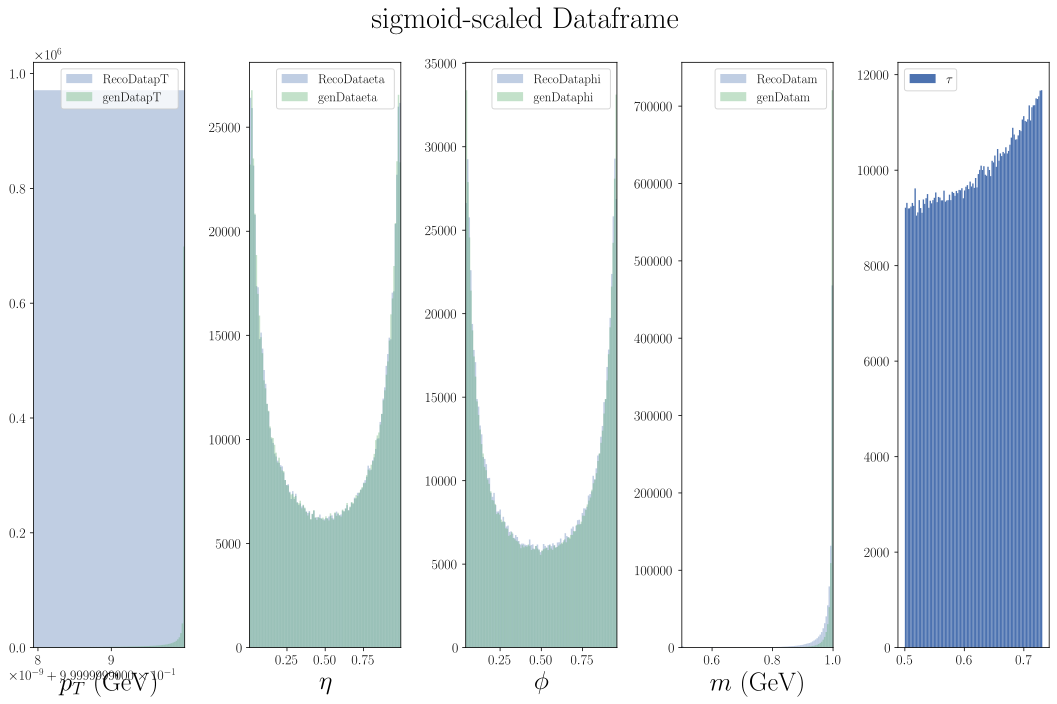

In [149]:
sigmoid_scaled_train_data = sigmoid_scale_df(train_data, title='sigmoid_scaled_train_data_10M_2.csv',
                             save=True)
print('\n\n')
sigmoid_scaled_test_data = sigmoid_scale_df(test_data,  title='sigmoid_scaled_test_data_10M_2.csv',
                            save=True)

explore_data(df=sigmoid_scaled_train_data, title='sigmoid-scaled Dataframe', scaled=True)

---------
------
# ML

Note that this ideas is very powerful and has the potential to replace the use of Delphes/GEANT for most people. According to the [previous paper](https://arxiv.org/pdf/2111.11415.pdf) this method already works for a single IQN.

It's important to remember "the master formula" of all of machine learning:

$$\int \frac{\partial L}{\partial f} p(y|x) dy  = 0 \tag{1}$$

or, equivalently, 

$$ \frac{\delta R}{\delta f}=0,$$

where $L$ is the loss function, $f$ is the model (in this case IQN) (implicitly parameterized by potentially a  gazillion parameters), $y$ is the target(s) that we want to estimate, $x$ is the (set of) training features, $R$ is the risk functional:

$$ R[f] = \int \cdots \int \, p(t, \mathbf{x}) \, L(t, f(\mathbf{x}, \theta)) \, dt \, d\mathbf{x}$$


So, for IQNs,

$$ L_{\text{IQN}}(f, y)=\left\{\begin{array}{ll}
\tau(y-f(\boldsymbol{x}, \tau ; \boldsymbol{\theta})) & y \geq f(\boldsymbol{x}, \tau ; \boldsymbol{\theta}) \\
(1-\tau)(f(\boldsymbol{x}, \tau ; \boldsymbol{\theta})-y) & y<f(\boldsymbol{x}, \tau ; \boldsymbol{\theta})
\end{array},\right.$$

Means that what was done previously is that the risk functional, which is generally a functional of many models $f$, was a only a functional of a single model: $R[f_1,..., f_n] = f[f_1]$. Here we have 4 models 

$$R_{\text{IQN}x4} =R_{\text{IQN}}[f_m, f_{p_T}, f_\eta, f_\phi], $$ 

and since we're choosing the evaluation order:

$$
\begin{align}
    p(\mathbf{y} | \mathbf{x}) & = 
    p(m'|\mathbf{x} )\nonumber\\
    & \times p(p_T'|\mathbf{x}, m' )\nonumber\\
    & \times p(\eta'| \mathbf{x}, m', p_T' )\nonumber\\
      & \times p(\phi' |  \mathbf{x}, m', p_T', \eta' ) ,
\end{align}

$$



$$ \begin{align}
R_{\text{IQN}x4} &= \int L_\text{IQN} \left( f_m (\mathbf{x_m},\tau), \mathbf{y_m} \right) p(\mathbf{x_m, y_m})  d \mathbf{x_m} d \mathbf{y_m} \\
&\times \  ... \times \\ 
&\times \int L_\text{IQN} \left( f_\phi (\mathbf{x_\phi},\tau), \mathbf{y_\phi} \right) p(\mathbf{x_\phi, y_\phi})  d \mathbf{x_\phi} d \mathbf{y_\phi}
\end{align},$$

where, again, each model $f_i$ is also dependent on a set of parameters $\theta_i$ (dropped for simplicity)

Our risk functional is minimized for

$$\frac{\delta R_{\text{IQN}x4} }{\delta f_m}=0\tag{5}$$

(which is basically what's done in the training process to get $f_m^{*}$ whose weights/parameters minimize the loss). Suppose we factorize the risk as

$$ R_{\text{IQN}x4}  = R_{\text{IQN}}^m \ R_{\text{IQN}}^{p_T}  \ R_{\text{IQN}}^\eta \ R_{\text{IQN}}^\phi \tag{6},$$ 

then, by Eq (4),

$$R_{\text{IQN}}^m \equiv \int L_\text{IQN} \left( f_m (\mathbf{x_m},\tau), \mathbf{y_m} \right) p(\mathbf{x_m, y_m,\tau})  d \mathbf{x_m} d \mathbf{y_m} d \mathbf{\tau},
$$
and by Eq (5)
$$\int d \mathbf{x_m} d \mathbf{y_m} d \mathbf{\tau} \ p(\mathbf{x_m, y_m,\tau})   \ \frac{ \delta L_\text{IQN} \left( f_m (\mathbf{x_m},\tau), \mathbf{y_m} \right) }{\delta f_m} = 0$$

and by Eq (2)

$$
\int d \mathbf{x_m} d \mathbf{y_m} d \mathbf{\tau} \ p(\mathbf{x_m, y_m,\tau})   \ \frac{ \delta L_\text{IQN} \left( f_m (\mathbf{x_m},\tau), \mathbf{y_m} \right) }{\delta f_m} = 0 \tag{7}
$$
>> ...
<br>

Expand Eq (2) in Eq (7) and integrate wrt y to see that  $f(\mathbf{x},\mathbf{\tau})$ is the quantile function for $p(\mathbf{y}|\mathbf{x})$, i.e. (I believe) that IQNx4 should work basically exactly.

$$R_{\text{IQN}x4} = [ L \left( f_m( \{ p_T^{\text{gen}}, \eta^{\text{gen}}, \phi^{\text{gen}}, m^{\text{gen}} , \tau \}, m^\text{reco} ) $$
# Train Mass

for mass, $\mathbf{y_m}=m_{\text{reco}}$ and $\mathbf{x_m}=\{p_T^{\text{gen}}, \eta^{\text{gen}}, \phi^{\text{gen}}, m^{\text{gen}} , \tau \}$.


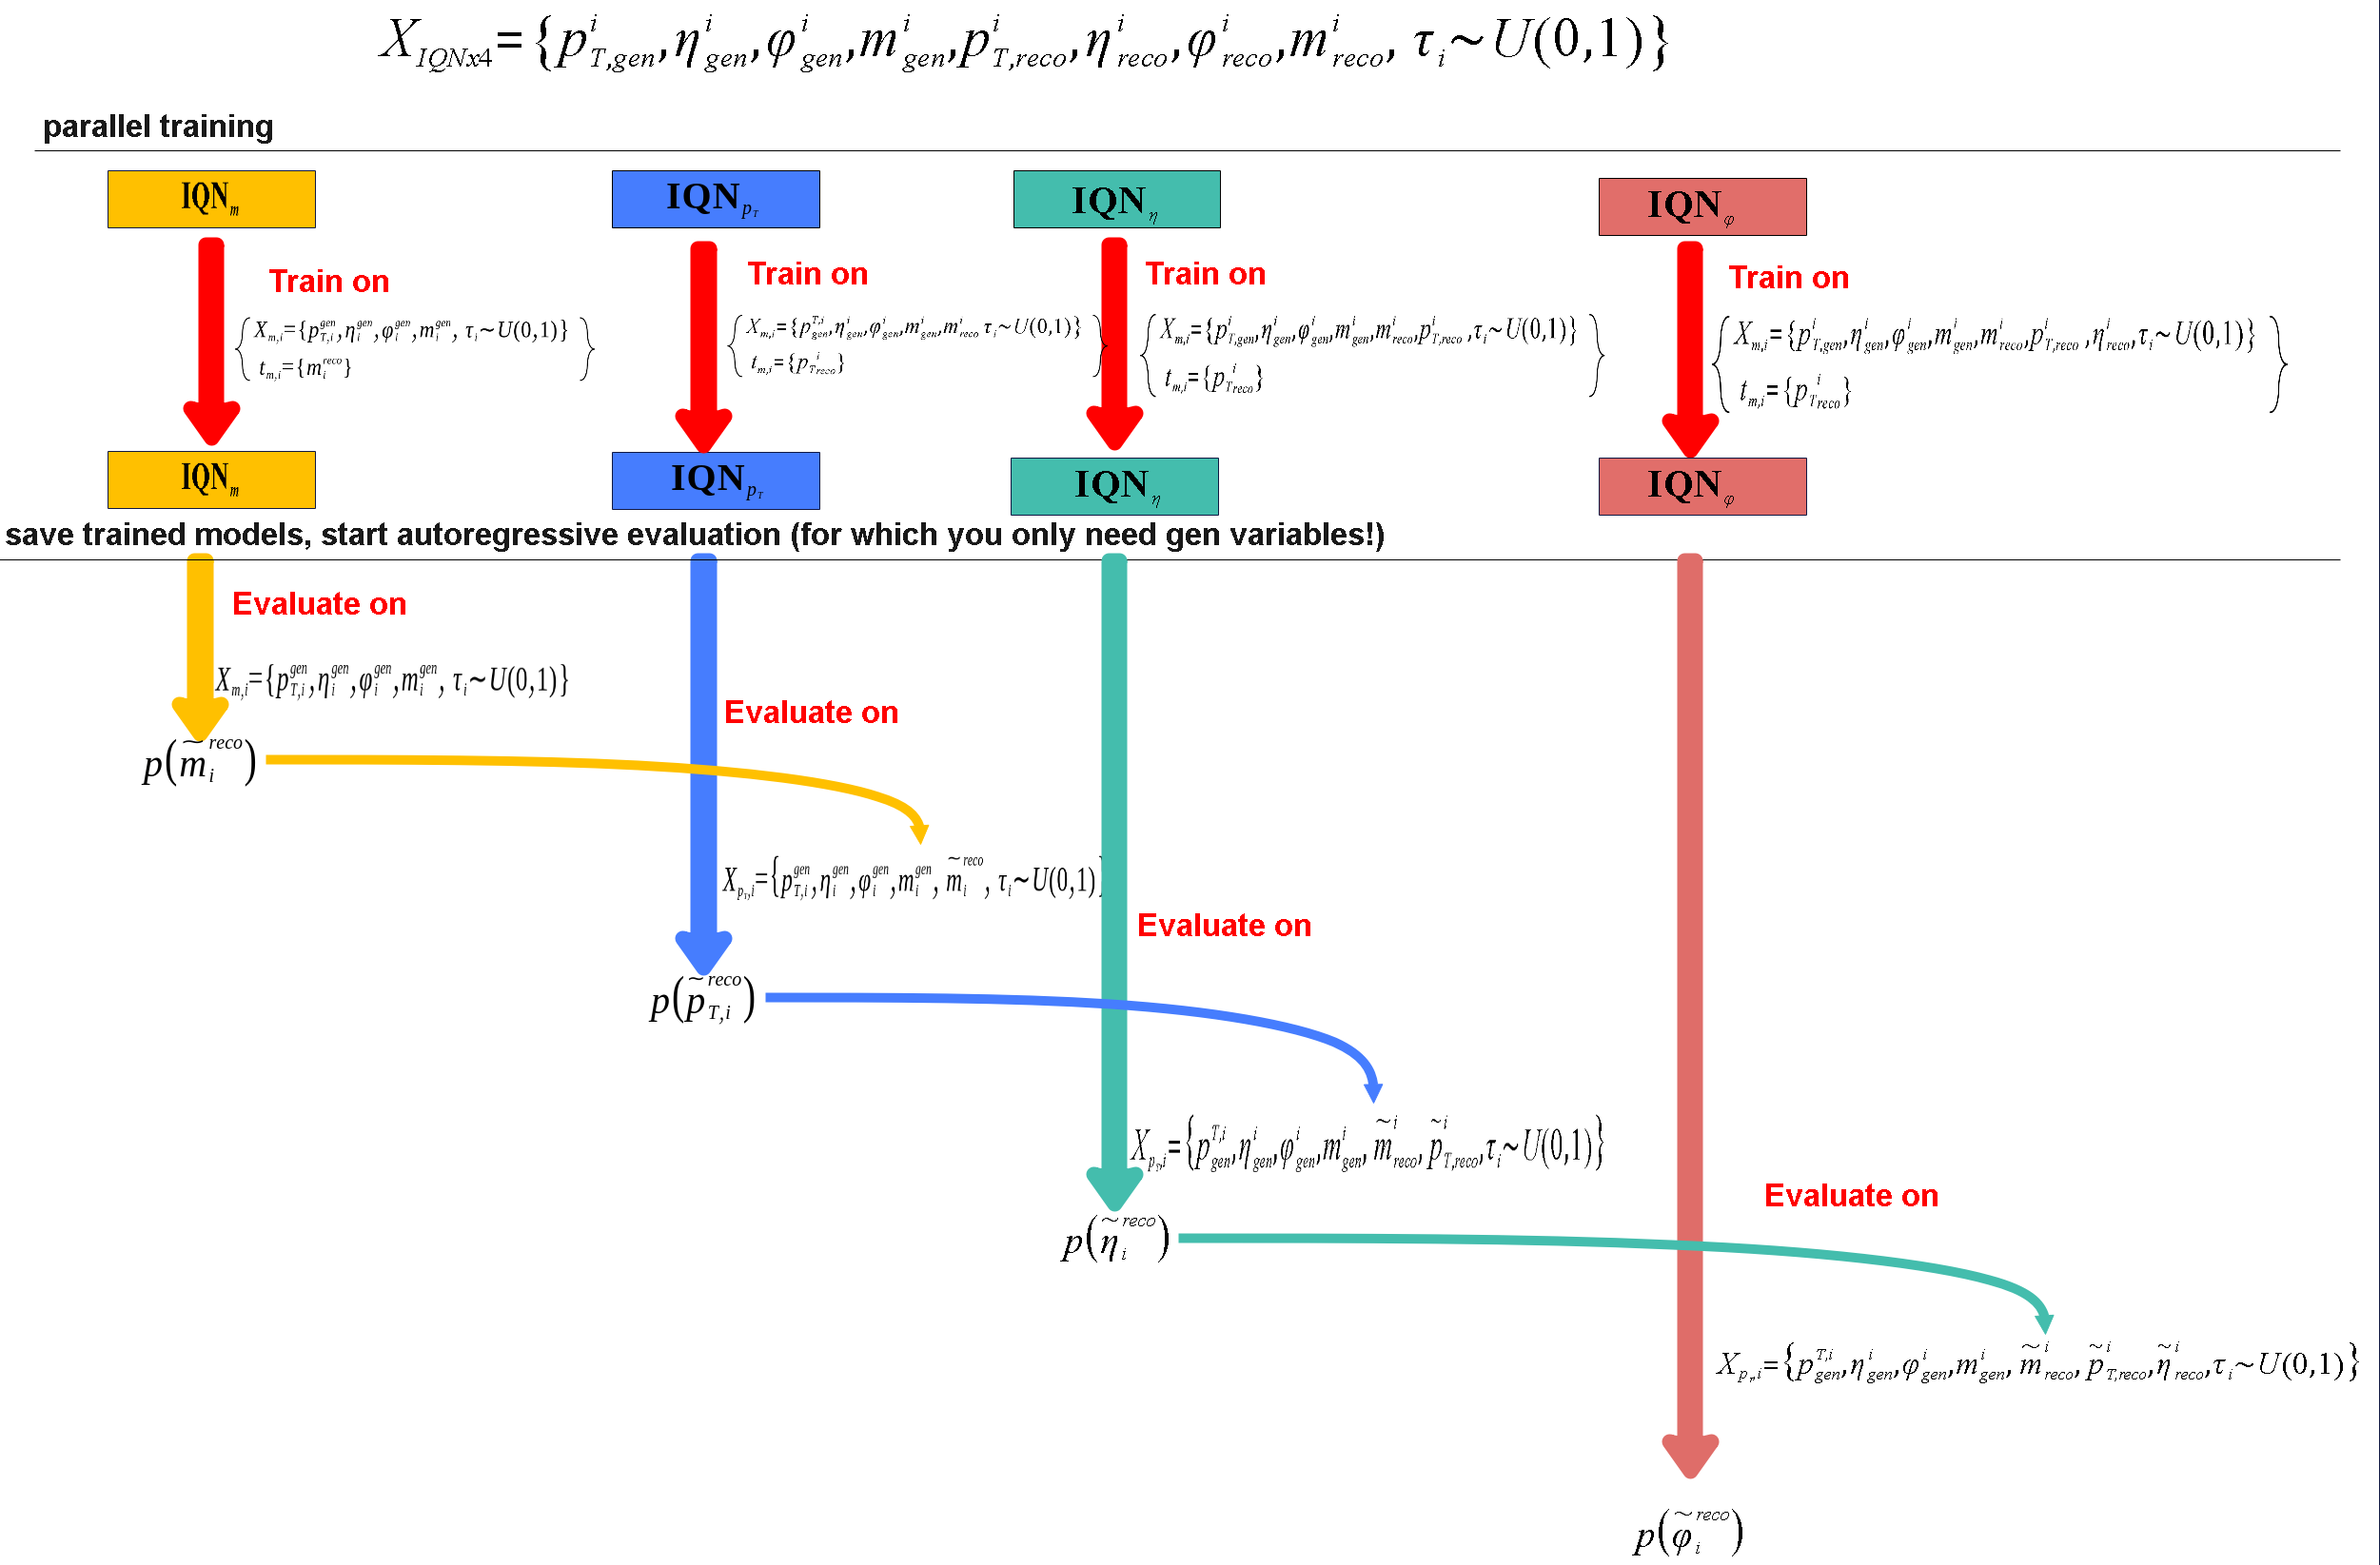

In [150]:
show_jupyter_image('images/IQN_training_flowchart.png',width=2000,height=600)

### Batches, validation, losses, and plotting of losses functions

In [151]:
def get_batch(x, t, batch_size):
    # the numpy function choice(length, number)
    # selects at random "batch_size" integers from 
    # the range [0, length-1] corresponding to the
    # row indices.
    rows    = np.random.choice(len(x), batch_size)
    batch_x = x[rows]
    batch_t = t[rows]
    # batch_x.T[-1] = np.random.uniform(0, 1, batch_size)
    return (batch_x, batch_t)

# Note: there are several average loss functions available 
# in pytorch, but it's useful to know how to create your own.
def average_quadratic_loss(f, t, x):
    # f and t must be of the same shape
    return  torch.mean((f - t)**2)

def average_cross_entropy_loss(f, t, x):
    # f and t must be of the same shape
    loss = torch.where(t > 0.5, torch.log(f), torch.log(1 - f))
    return -torch.mean(loss)

def average_quantile_loss(f, t, x):
    # f and t must be of the same shape
    tau = x.T[-1] # last column is tau.
    #Eq (2)
    return torch.mean(torch.where(t >= f, 
                                  tau * (t - f), 
                                  (1 - tau)*(f - t)))

# function to validate model during training.
def validate(model, avloss, inputs, targets):
    # make sure we set evaluation mode so that any training specific
    # operations are disabled.
    model.eval() # evaluation mode
    
    with torch.no_grad(): # no need to compute gradients wrt. x and t
        x = torch.from_numpy(inputs).float()
        t = torch.from_numpy(targets).float()
        # remember to reshape!
        o = model(x).reshape(t.shape)
    return avloss(o, t, x)


def mkdir(dir_):
    """make a directory without overwriting what's in it if it exists"""
    # assert isinstance(dir_, str)
    try:
        os.system('mkdir -p %s' % str(dir_) )
    except Exception:
        pass


def plot_average_loss(traces, ftsize=18,save_loss_plots=False, show_loss_plots=True):
    
    xx, yy_t, yy_v, yy_v_avg = traces
    
    # create an empty figure
    fig = plt.figure(figsize=(6, 4.5))
    fig.tight_layout()
    
    # add a subplot to it
    nrows, ncols, index = 1,1,1
    ax  = fig.add_subplot(nrows,ncols,index)

    ax.set_title("Average loss")
    
    ax.plot(xx, yy_t, 'b', lw=2, label='Training')
    ax.plot(xx, yy_v, 'r', lw=2, label='Validation')
    #ax.plot(xx, yy_v_avg, 'g', lw=2, label='Running average')

    ax.set_xlabel('Iterations', fontsize=ftsize)
    ax.set_ylabel('average loss', fontsize=ftsize)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.grid(True, which="both", linestyle='-')
    ax.legend(loc='upper right')
    if save_loss_plots:
        filename='IQNx4_%s_Loss.png' % target 
        mkdir('images/loss_plots')
        PATH = os.path.join(IQN_BASE, 'images', 'loss_plots', filename)
        plt.savefig('images/loss_curves/IQN_'+N+T+'_Consecutive_2.png')
        print('\nloss curve saved in images/loss_curves/IQN_'+N+target+'_Consecutive.png')
    if show_loss_plots:
        plt.show()

In [153]:
SUBSAMPLE=int(1e6)
target = 'RecoDatam'
source  = FIELDS[target]
features= source['inputs']
########

print('USING NEW DATASET\n')
#UNSCALED
# train_data_m=pd.read_csv(os.path.join(DATA_DIR,'train_data_10M_2.csv'),
#                        usecols=features,
#                        nrows=SUBSAMPLE)

# print('TRAINING FEATURES\n', train_data.head())

# test_data_m= pd.read_csv(os.path.join(DATA_DIR,'test_data_10M_2.csv'),
#                        usecols=features,
#                        nrows=SUBSAMPLE)
# print('\nTESTING FEATURES\n', test_data.head())
# valid_data= pd.read_csv(os.path.join(DATA_DIR,'valid_data_10M_2.csv'),
#                        usecols=features,
#                        nrows=SUBSAMPLE)


# SCALED
train_data_m=pd.read_csv(os.path.join(DATA_DIR,'sigmoid_scaled_train_data_10M_2.csv'),
                       usecols=all_cols,
                       nrows=SUBSAMPLE)

print('TRAINING FEATURES\n', train_data_m.head())

test_data_m= pd.read_csv(os.path.join(DATA_DIR,'sigmoid_scaled_test_data_10M_2.csv'),
                       usecols=all_cols,
                       nrows=SUBSAMPLE)
print('\nTESTING FEATURES\n', test_data_m.head())

print('\ntrain set shape:',  train_data_m.shape)
print('\ntest set shape:  ', test_data_m.shape)
# print('validation set shape:', valid_data.shape)

USING NEW DATASET

TRAINING FEATURES
    genDatapT  RecoDatapT  genDataeta  RecoDataeta  genDataphi  RecoDataphi  \
0        1.0         1.0    0.695971     0.693617    0.947952     0.948803   
1        1.0         1.0    0.238030     0.240303    0.653955     0.657495   
2        1.0         1.0    0.238030     0.240303    0.653955     0.657495   
3        1.0         1.0    0.238030     0.240303    0.653955     0.657495   
4        1.0         1.0    0.863469     0.862701    0.453464     0.459931   

   genDatam  RecoDatam       tau  
0  0.945498   0.930595  0.589357  
1  0.997090   0.995300  0.531682  
2  0.997090   0.995300  0.723583  
3  0.997090   0.995300  0.612369  
4  0.996635   0.989986  0.698647  

TESTING FEATURES
    genDatapT  RecoDatapT  genDataeta  RecoDataeta  genDataphi  RecoDataphi  \
0        1.0         1.0    0.695274     0.695221    0.219345     0.220773   
1        1.0         1.0    0.695274     0.695221    0.219345     0.220773   
2        1.0         1.0    0.

### Get training and testing features and targets

In [154]:
target = 'RecoDatam'
source  = FIELDS[target]
features= source['inputs']
################################################
def split_t_x(df, target, input_features):
    """ Get teh target as the ratio, according to the T equation"""
    
    if target=='RecoDatam':
        t = T('m', scaled_df=train_data_m)
    if target=='RecoDatapT':
        t = T('pT', scaled_df=train_data_m)
    if target=='RecoDataeta':
        t = T('eta', scaled_df=train_data_m)
    if target=='RecoDataphi':
        t = T('phi', scaled_df=train_data_m)
    x = np.array(df[input_features])
    return np.array(t), x

def normal_split_t_x(df, target, input_features):
    # change from pandas dataframe format to a numpy 
    # array of the specified types
    # t = np.array(df[target])
    t = np.array(df[target])
    x = np.array(df[input_features])
    return t, x


In [155]:
print(f'spliting data for {target}')
train_t, train_x = normal_split_t_x(df= train_data_m, target = target, input_features=features)
print('train_t shape = ',train_t.shape , 'train_x shape = ', train_x.shape)
print('\n Training features:\n')
print(train_x)
valid_t, valid_x = normal_split_t_x(df= test_data_m, target = target, input_features=features)
print('valid_t shape = ',valid_t.shape , 'valid_x shape = ', valid_x.shape)

print('no need to train_test_split since we already have the split dataframes')



spliting data for RecoDatam
train_t shape =  (1000000,) train_x shape =  (1000000, 5)

 Training features:

[[1.         0.69597144 0.94795163 0.94549829 0.5893574 ]
 [1.         0.23803009 0.65395484 0.99709047 0.53168231]
 [1.         0.23803009 0.65395484 0.99709047 0.72358343]
 ...
 [1.         0.89154591 0.31755628 0.98977022 0.70283058]
 [1.         0.24608363 0.31354969 0.99997578 0.69798035]
 [1.         0.14178413 0.35840652 0.9731878  0.65862557]]
valid_t shape =  (1000000,) valid_x shape =  (1000000, 5)
no need to train_test_split since we already have the split dataframes


In [156]:
def train(model, optimizer, avloss, getbatch,
          train_x, train_t, 
          valid_x, valid_t,
          batch_size, 
          n_iterations, traces, 
          step=10, window=10):
    
    # to keep track of average losses
    xx, yy_t, yy_v, yy_v_avg = traces
    
    n = len(valid_x)
    
    print('Iteration vs average loss')
    print("%10s\t%10s\t%10s" % \
          ('iteration', 'train-set', 'valid-set'))
    
    for ii in range(n_iterations):

        # set mode to training so that training specific 
        # operations such as dropout are enabled.
        model.train()
        
        # get a random sample (a batch) of data (as numpy arrays)
        batch_x, batch_t = getbatch(train_x, train_t, batch_size)
        
        # convert the numpy arrays batch_x and batch_t to tensor 
        # types. The PyTorch tensor type is the magic that permits 
        # automatic differentiation with respect to parameters. 
        # However, since we do not need to take the derivatives
        # with respect to x and t, we disable this feature
        with torch.no_grad(): # no need to compute gradients 
            # wrt. x and t
            x = torch.from_numpy(batch_x).float()
            t = torch.from_numpy(batch_t).float()      

        # compute the output of the model for the batch of data x
        # Note: outputs is 
        #   of shape (-1, 1), but the tensor targets, t, is
        #   of shape (-1,)
        # In order for the tensor operations with outputs and t
        # to work correctly, it is necessary that they have the
        # same shape. We can do this with the reshape method.
        outputs = model(x).reshape(t.shape)
   
        # compute a noisy approximation to the average loss
        empirical_risk = avloss(outputs, t, x)
        
        # use automatic differentiation to compute a 
        # noisy approximation of the local gradient
        optimizer.zero_grad()       # clear previous gradients
        empirical_risk.backward()   # compute gradients
        
        # finally, advance one step in the direction of steepest 
        # descent, using the noisy local gradient. 
        optimizer.step()            # move one step
        
        if ii % step == 0:
            
            acc_t = validate(model, avloss, train_x[:n], train_t[:n]) 
            acc_v = validate(model, avloss, valid_x[:n], valid_t[:n])
            yy_t.append(acc_t)
            yy_v.append(acc_v)
            
            # compute running average for validation data
            len_yy_v = len(yy_v)
            if   len_yy_v < window:
                yy_v_avg.append( yy_v[-1] )
            elif len_yy_v == window:
                yy_v_avg.append( sum(yy_v) / window )
            else:
                acc_v_avg  = yy_v_avg[-1] * window
                acc_v_avg += yy_v[-1] - yy_v[-window-1]
                yy_v_avg.append(acc_v_avg / window)
                        
            if len(xx) < 1:
                xx.append(0)
                print("%10d\t%10.6f\t%10.6f" % \
                      (xx[-1], yy_t[-1], yy_v[-1]))
            else:
                xx.append(xx[-1] + step)
                    
                print("\r%10d\t%10.6f\t%10.6f\t%10.6f" % \
                          (xx[-1], yy_t[-1], yy_v[-1], yy_v_avg[-1]), 
                      end='')
            
    print()      
    return (xx, yy_t, yy_v, yy_v_avg)


def run(model, target, 
        train_x, train_t, 
        valid_x, valid_t, traces,
        n_batch=256, 
        n_iterations=n_iterations, 
        traces_step=500, 
        traces_window=500,
        save_model=False):

    learning_rate= starting_learning_rate
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 
    #starting at 10^-3	    
    traces = train(model, optimizer, 
                      average_quantile_loss,
                      get_batch,
                      train_x, train_t, 
                      valid_x, valid_t,
                      n_batch, 
                  n_iterations,
                  traces,
                  step=traces_step, 
                  window=traces_window)
    
    # learning_rate=learning_rate/10
    # optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 
    # #10^-4
    # traces = train(model, optimizer, 
    #                   average_quantile_loss,
    #                   get_batch,
    #                   train_x, train_t, 
    #                   valid_x, valid_t,
    #                   n_batch, 
    #               n_iterations,
    #               traces,
    #               step=traces_step, 
    #               window=traces_window)


    # learning_rate=learning_rate/100
    # optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 
    # #10^-6
    # traces = train(model, optimizer, 
    #                   average_quantile_loss,
    #                   get_batch,
    #                   train_x, train_t, 
    #                   valid_x, valid_t,
    #                   n_batch, 
    #               n_iterations,
    #               traces,
    #               step=traces_step, 
    #               window=traces_window)

    plot_average_loss(traces)

    if save_model:
        filename='Trained_IQNx4_%s_%sK_iter.dict' % (target, str(int(n_iterations/1000)) )
        PATH = os.path.join(IQN_BASE, 'trained_models', filename)
        torch.save(model.state_dict(), PATH)
        print('\ntrained model dictionary saved in %s' % PATH)
    #utils.ModelHandler(model, scalers)
    return  model

### Define basic NN model

In [157]:
class RegularizedRegressionModel(nn.Module):
    #inherit from the super class
    def __init__(self, nfeatures, ntargets, nlayers, hidden_size, dropout):
        super().__init__()
        layers = []
        for _ in range(nlayers):
            if len(layers) ==0:
                #inital layer has to have size of input features as its input layer
                #its output layer can have any size but it must match the size of the input layer of the next linear layer
                #here we choose its output layer as the hidden size (fully connected)
                layers.append(nn.Linear(nfeatures, hidden_size))
                #batch normalization
                # layers.append(nn.BatchNorm1d(hidden_size))
                #Dropout seems to worsen model performance
                # layers.append(nn.Dropout(dropout))
                #ReLU activation 
                layers.append(nn.ReLU())
            else:
                #if this is not the first layer (we dont have layers)
                layers.append(nn.Linear(hidden_size, hidden_size))
                # layers.append(nn.BatchNorm1d(hidden_size))
                #Dropout seems to worsen model performance
                # layers.append(nn.Dropout(dropout))
                layers.append(nn.ReLU())
                #output layer:
        layers.append(nn.Linear(hidden_size, ntargets)) 

        # only for classification add sigmoid
        # layers.append(nn.Sigmoid())
            #we have defined sequential model using the layers in oulist 
        self.model = nn.Sequential(*layers)

    
    def forward(self, x):
        return self.model(x)

Training for 10000 iterations
estimating RecoDatam

Iteration vs average loss
 iteration	 train-set	 valid-set
         0	  0.713377	  0.713499
      9950	  0.007001	  0.006944	  0.007330


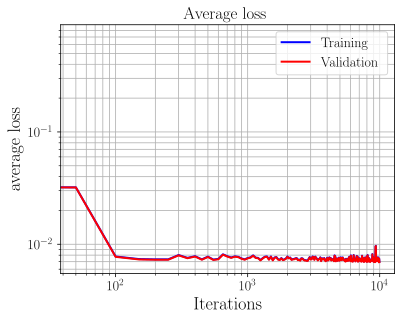

evaluating m took  30.026453971862793 seconds


In [158]:
n_iterations, n_layers, n_hidden, starting_learning_rate, dropout = get_model_params()
def load_untrained_model():
    NFEATURES=train_x.shape[1]
    model=RegularizedRegressionModel(nfeatures=NFEATURES, ntargets=1,
                               nlayers=n_layers, hidden_size=n_hidden, dropout=dropout)
    return model

model=load_untrained_model()

print(f'Training for {n_iterations} iterations')
start=time.time()
print('estimating %s\n' % target)
IQN_trace=([], [], [], [])
traces_step = 50
n_iterations=10000
IQN = run(model=model, target=target,train_x=train_x, train_t=train_t, 
        valid_x=valid_x, valid_t=valid_t, traces=IQN_trace, n_batch=2560, 
        n_iterations=n_iterations, traces_step=50, traces_window=50,
        save_model=False)

end=time.time()
difference=end-start
print('evaluating m took ',difference, 'seconds')

In [175]:
def inverse_sigmoid(scaled_values):
    try:
        factor = (1/scaled_values) - 1
    except ZeroDivisionError:
        factor=-1
    return - np.log(factor)

In [120]:
def minmax_descale_mass(scaled_values):
    expected_values=train_data.iloc[:,7]
    expected_min, expected_max = expected_values.min(), expected_values.max()
    desired_min, desired_max = 2, 7
    factor = (expected_max-expected_min)/(desired_max-desired_min)
    descaled_values = scaled_values  - ( desired_min* factor) + expected_min
    return descaled_values

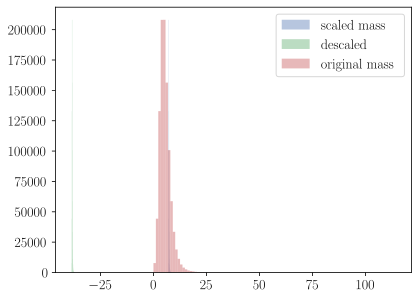

In [121]:
m_scaled = train_data_m.iloc[:,7]
bins=100
m_descaled=minmax_descale_mass(m_scaled)
plt.hist(m_scaled, label='scaled mass',bins=bins,alpha=0.4)
plt.hist(m_descaled,label='descaled',bins=bins,alpha=0.4);
plt.hist(train_data.iloc[:,7],label='original mass',bins=bins,alpha=0.4);
plt.legend();plt.show()

In [160]:
valid_x

array([[1.        , 0.69527358, 0.21934457, 0.99735675, 0.56218772],
       [1.        , 0.69527358, 0.21934457, 0.99735675, 0.70004088],
       [1.        , 0.97152858, 0.82562752, 0.99939683, 0.70098553],
       ...,
       [1.        , 0.79909698, 0.3282656 , 0.99929769, 0.61736028],
       [1.        , 0.01314269, 0.69192493, 0.99685255, 0.58026137],
       [1.        , 0.24754478, 0.54892619, 0.99910968, 0.60979776]])

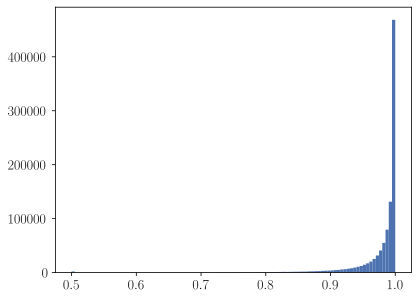

/home/ali/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


array([5.8027 , 5.8027 , 4.81403, ..., 5.61202, 4.79926, 5.89424])

In [176]:
plt.hist(valid_t,bins=100);plt.show()
inverse_sigmoid(valid_t)

/home/ali/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


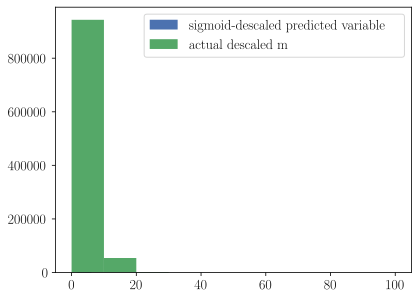

In [183]:
def simple_eval(model):
    model.eval()
    #evaluate on scaled values (since trained on scaled values)
    valid_x_tensor=torch.from_numpy(valid_x).float()
    pred = IQN(valid_x_tensor)
    p = pred.detach().numpy()
    predicted_var = inverse_sigmoid(p)

    plt.hist(predicted_var, label='sigmoid-descaled predicted variable');
    actual_unscaled_m = inverse_sigmoid(valid_t)
    plt.hist(actual_unscaled_m,label='actual descaled m',range=(0,100))
    plt.legend();plt.show()
    
simple_eval(IQN)

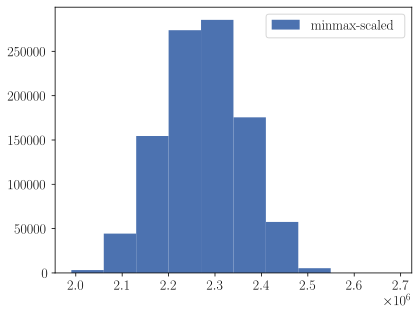

In [111]:
def simple_eval(model):
    model.eval()
    #evaluate on scaled values (since trained on scaled values)
    valid_x_tensor=torch.from_numpy(valid_x).float()
    pred = IQN(valid_x_tensor)
    p = pred.detach().numpy()
    predicted_var = minmax_descale_mass(p)

    plt.hist(predicted_var, label='minmax-scaled');plt.legend();plt.show()
    
simple_eval(IQN)